(perm_income)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# {index}`The Permanent Income Model <single: The Permanent Income Model>`

```{index} single: Models; Permanent Income
```

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

This lecture describes a rational expectations version of the famous permanent income model of Milton Friedman {cite}`Friedman1956`.

Robert Hall cast Friedman's model within a linear-quadratic setting {cite}`Hall1978`.

Like Hall, we formulate an infinite-horizon linear-quadratic savings problem.

We use the model as a vehicle for illustrating

* alternative formulations of the *state* of a dynamic system
* the idea of *cointegration*
* impulse response functions
* the idea that changes in consumption are useful as predictors of movements in income

Background readings on the linear-quadratic-Gaussian permanent income model are Hall's  {cite}`Hall1978`  and chapter 2 of  {cite}`Ljungqvist2012`.

Let's start with some imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import random
from numba import njit

## The Savings Problem

```{index} single: Permanent Income Model; Savings Problem
```

In this section, we state and solve the savings and consumption problem faced
by the consumer.

### Preliminaries

We use a class of stochastic processes called
[martingales](https://en.wikipedia.org/wiki/Martingale_%28probability_theory%29).

A discrete-time martingale is a stochastic process (i.e., a  sequence of random variables)
$\{X_t\}$ with finite mean at each $t$ and satisfying

$$
\mathbb{E}_t [X_{t+1} ] = X_t, \qquad t = 0, 1, 2, \ldots
$$

Here $\mathbb{E}_t := \mathbb{E}[ \cdot \,|\, \mathcal{F}_t]$ is a conditional mathematical  expectation conditional on the time $t$
*information set* $\mathcal{F}_t$.

The latter is just a collection of random variables that the modeler declares
to be visible at $t$.

* When not explicitly defined, it is usually understood that $\mathcal{F}_t = \{X_t, X_{t-1}, \ldots, X_0\}$.

Martingales have the feature that the history of past outcomes provides no predictive power for changes between current and future outcomes.

For example, the current wealth of a gambler engaged in a "fair game" has this
property.

One common class of martingales is the family of *random walks*.

A **random walk** is  a stochastic process $\{X_t\}$ that satisfies

$$
X_{t+1} = X_t + w_{t+1}
$$

for some IID zero mean *innovation* sequence $\{w_t\}$.

Evidently, $X_t$ can also be expressed as

$$
X_t = \sum_{j=1}^t w_j + X_0
$$

Not every martingale arises as a random walk (see, for example, [Wald's martingale](https://en.wikipedia.org/wiki/Wald%27s_martingale)).

### The Decision Problem

A consumer has preferences over consumption streams that are ordered by the utility functional

```{math}
:label: sprob1

\mathbb{E}_0 \left[ \sum_{t=0}^\infty \beta^t u(c_t) \right]
```

where

* $\mathbb{E}_t$ is the mathematical expectation conditioned on the consumer's time $t$ information
* $c_t$ is time $t$ consumption
* $u$ is a strictly concave one-period utility function
* $\beta \in (0,1)$ is a discount factor

The consumer maximizes {eq}`sprob1` by choosing a consumption, borrowing plan $\{c_t, b_{t+1}\}_{t=0}^\infty$ subject to the sequence of budget constraints

```{math}
:label: sprob2

c_t + b_t = \frac{1}{1 + r} b_{t+1} +  y_t   \quad t \geq 0
```

Here

* $y_t$ is an exogenous endowment process.
* $r > 0$ is a time-invariant risk-free net interest rate.
* $b_t$ is one-period risk-free debt maturing at $t$.

The consumer also faces initial conditions $b_0$ and $y_0$, which can be fixed or random.

### Assumptions

For the remainder of this lecture, we follow Friedman and Hall in assuming that $(1 + r)^{-1} = \beta$.

Regarding the endowment process, we assume it has the {doc}`state-space representation <linear_models>`

```{math}
:label: sprob15ab

\begin{aligned}
    z_{t+1} & = A z_t + C w_{t+1}
    \\
    y_t & = U  z_t
\end{aligned}
```

where

* $\{w_t\}$ is an IID vector process with $\mathbb{E} w_t = 0$ and $\mathbb{E} w_t w_t' = I$.
* The {ref}`spectral radius <la_neumann_remarks>` of $A$ satisfies $\rho(A) < \sqrt{1/\beta}$.
* $U$ is a selection vector that pins down $y_t$ as a particular linear combination of components of $z_t$.

The restriction on $\rho(A)$ prevents income from growing so fast that discounted geometric sums of some quadratic forms to be described below become infinite.

Regarding preferences, we assume the quadratic utility function

$$
u(c_t) =  - (c_t - \gamma)^2
$$

where $\gamma$ is a bliss level of consumption.

```{note}
Along with this quadratic utility specification, we allow consumption to be negative.  However, by choosing parameters appropriately, we can make the probability that the model generates negative consumption paths over finite time horizons as low as desired.
```

Finally, we impose the *no Ponzi scheme* condition

```{math}
:label: sprob3

\mathbb{E}_0 \left[ \sum_{t=0}^\infty \beta^t b_t^2 \right] < \infty
```

This condition rules out an always-borrow scheme that would allow the consumer to enjoy bliss consumption forever.

### First-Order Conditions

First-order conditions for maximizing {eq}`sprob1` subject to {eq}`sprob2` are

```{math}
:label: sprob4

\mathbb{E}_t [u'(c_{t+1})] = u'(c_t) , \qquad t = 0, 1, \ldots
```

These optimality conditions are also known as  *Euler equations*.

If you're not sure where they come from, you can find a proof sketch in the
{ref}`appendix <perm_income_appendix>`.

With our quadratic preference specification, {eq}`sprob4` has the striking implication that consumption follows a martingale:

```{math}
:label: sprob5

\mathbb{E}_t [c_{t+1}] = c_t
```

(In fact, quadratic preferences are *necessary* for this conclusion [^f2].)

One way to interpret {eq}`sprob5` is that consumption will change only when
"new information" about permanent income is revealed.

These ideas will be clarified below.

(odr_pi)=
### The Optimal Decision Rule

Now let's deduce the optimal decision rule [^fod].

```{note}
One way to solve the consumer's problem is to apply *dynamic programming*
as in {doc}`this lecture <lqcontrol>`.  We do this later. But first we use
an alternative approach that is revealing and shows the work that dynamic
programming does for us behind the scenes.
```

In doing so, we need to combine

1. the optimality condition {eq}`sprob5`
1. the period-by-period budget constraint {eq}`sprob2`, and
1. the boundary condition {eq}`sprob3`

To accomplish this, observe first that {eq}`sprob3` implies $\lim_{t \to \infty} \beta^{\frac{t}{2}} b_{t+1}= 0$.

Using this restriction on the debt path and solving {eq}`sprob2` forward yields

```{math}
:label: sprob6

b_t = \sum_{j=0}^\infty \beta^j (y_{t+j} - c_{t+j})
```

Take conditional expectations on both sides of {eq}`sprob6` and use the martingale property of consumption and the *law of iterated expectations* to deduce

```{math}
:label: sprob7

b_t = \sum_{j=0}^\infty \beta^j \mathbb{E}_t [y_{t+j}] - \frac{c_t}{1-\beta}
```

Expressed in terms of $c_t$ we get

```{math}
:label: sprob8

c_t
 = (1-\beta) \left[ \sum_{j=0}^\infty \beta^j \mathbb{E}_t [y_{t+j}] - b_t\right]
 = {r \over 1+r} \left[ \sum_{j=0}^\infty \beta^j \mathbb{E}_t [y_{t+j}] - b_t\right]
```

where the last equality uses $(1 + r) \beta = 1$.

These last two equations assert that consumption equals *economic income*

* **financial wealth** equals $-b_t$
* **non-financial wealth** equals $\sum_{j=0}^\infty \beta^j \mathbb{E}_t [y_{t+j}]$
* **total wealth** equals the sum of financial and non-financial wealth
* a **marginal propensity to consume out of total wealth** equals the  interest factor $\frac{r}{1+r}$
* **economic income** equals
    * a constant marginal propensity to consume  times the sum of non-financial wealth and financial wealth
    * the amount the consumer can consume while leaving its wealth intact

#### Responding to the State

The *state* vector confronting the consumer at $t$ is $\begin{bmatrix} b_t & z_t \end{bmatrix}$.

Here

* $z_t$ is an *exogenous* component, unaffected by consumer behavior.
* $b_t$ is an *endogenous* component (since it depends on the decision rule).

Note that $z_t$ contains all variables useful for forecasting the consumer's future endowment.

It is plausible that current decisions $c_t$ and $b_{t+1}$ should
be expressible as functions of $z_t$ and $b_t$.

This is indeed the case.

In fact, from {ref}`this discussion <lm_fgs>`, we see that

$$
\sum_{j=0}^\infty \beta^j \mathbb{E}_t [y_{t+j}]
= \mathbb{E}_t \left[ \sum_{j=0}^\infty \beta^j y_{t+j} \right]
= U(I - \beta A)^{-1} z_t
$$

Combining this with {eq}`sprob8` gives

```{math}
:label: pi_cpa

c_t
 = {r \over 1+r}
     \left[
         U(I - \beta A)^{-1} z_t - b_t
     \right]
```

Using this equality to eliminate $c_t$ in the budget constraint {eq}`sprob2` gives

$$
\begin{aligned}
    b_{t+1}
    & = (1 + r) (b_t + c_t - y_t)
    \\
    & = (1 + r) b_t + r [ U(I - \beta A)^{-1} z_t - b_t]  - (1+r) U z_t
    \\
    & = b_t +  U [ r(I - \beta A)^{-1}  - (1+r) I ]  z_t
    \\
    & = b_t +  U (I - \beta A)^{-1} (A - I)   z_t
\end{aligned}
$$

To get from the second last to the last expression in this chain of equalities is not trivial.

A key is to use the fact that $(1 + r) \beta = 1$ and $(I - \beta A)^{-1} = \sum_{j=0}^{\infty} \beta^j A^j$.

We've now successfully written $c_t$ and $b_{t+1}$ as functions of $b_t$ and $z_t$.

#### A State-Space Representation

We can summarize our dynamics in the form of a linear state-space system governing consumption, debt and income:

```{math}
:label: pi_ssr

\begin{aligned}
  z_{t+1} & = A z_t + C w_{t+1} \\
  b_{t+1} & = b_t + U [ (I -\beta A)^{-1} (A - I) ] z_t \\
      y_t & = U z_t \\
      c_t & = (1-\beta) [ U(I-\beta A)^{-1} z_t - b_t ]
\end{aligned}
```

To write this more succinctly, let

$$
x_t =
\begin{bmatrix}
    z_t\\
    b_t
\end{bmatrix},
\quad
\tilde A =
\begin{bmatrix}
    A & 0 \\
    U(I-\beta A)^{-1}(A-I) & 1
 \end{bmatrix},
 \quad
\tilde C =
\begin{bmatrix}
    C\\
    0
\end{bmatrix}
$$

and

$$
\tilde U =
\begin{bmatrix}
    U & 0 \\
    (1-\beta) U (I - \beta A)^{-1} & -(1-\beta)
\end{bmatrix}, \quad
\tilde y_t =
\begin{bmatrix}
      y_t\\
      c_t
  \end{bmatrix}
$$

Then we can express equation  {eq}`pi_ssr` as

```{math}
:label: pi_stsp

\begin{aligned}
  x_{t+1} & = \tilde A x_t + \tilde C w_{t+1} \\
  \tilde y_t & = \tilde U x_t
\end{aligned}
```

We can use the following formulas from {doc}`linear state space models <linear_models>` to compute population mean $\mu_t = \mathbb{E}    x_t$ and covariance $\Sigma_t := \mathbb{E} [ (x_t - \mu_t) (x_t - \mu_t)']$

```{math}
:label: lss_mut_perm_income

\mu_{t+1} = \tilde A \mu_t
\quad \text{with} \quad \mu_0 \text{ given}
```

```{math}
:label: eqsigmalaw

\Sigma_{t+1}  = \tilde A  \Sigma_t \tilde A' + \tilde C \tilde C'
\quad \text{with} \quad \Sigma_0 \text{ given}
```

We can then compute the mean and covariance of $\tilde y_t$ from

```{math}
:label: eqymoments

\begin{aligned}
\mu_{y,t} = \tilde U \mu_t \\
\Sigma_{y,t} = \tilde U \Sigma_t \tilde U'
\end{aligned}
```

#### A Simple Example with IID Income

To gain some preliminary intuition on the implications of {eq}`pi_ssr`, let's look at a highly stylized example where income is just IID.

(Later examples will investigate more realistic income streams.)

In particular, let $\{w_t\}_{t = 1}^{\infty}$ be IID and scalar standard normal, and let

$$
z_t =
\begin{bmatrix}
    z^1_t \\
    1
\end{bmatrix},
\quad
A =
\begin{bmatrix}
    0 & 0 \\
    0 & 1
\end{bmatrix},
\quad
U =
\begin{bmatrix}
    1 & \mu
\end{bmatrix},
\quad
C =
\begin{bmatrix}
    \sigma \\
    0
\end{bmatrix}
$$

Finally, let $b_0 = z^1_0 = 0$.

Under these assumptions, we have $y_t = \mu + \sigma w_t \sim N(\mu, \sigma^2)$.

Further, if you work through the state space representation, you will see that

$$
\begin{aligned}
    b_t & = - \sigma \sum_{j=1}^{t-1} w_j
    \\
    c_t & = \mu + (1 - \beta) \sigma \sum_{j=1}^t w_j
\end{aligned}
$$

Thus, income is IID and debt and consumption are both Gaussian random walks.

Defining assets as $-b_t$, we see that assets are just the cumulative sum of unanticipated incomes prior to the present date.

The next figure shows a typical realization with $r = 0.05$, $\mu = 1$, and $\sigma = 0.15$

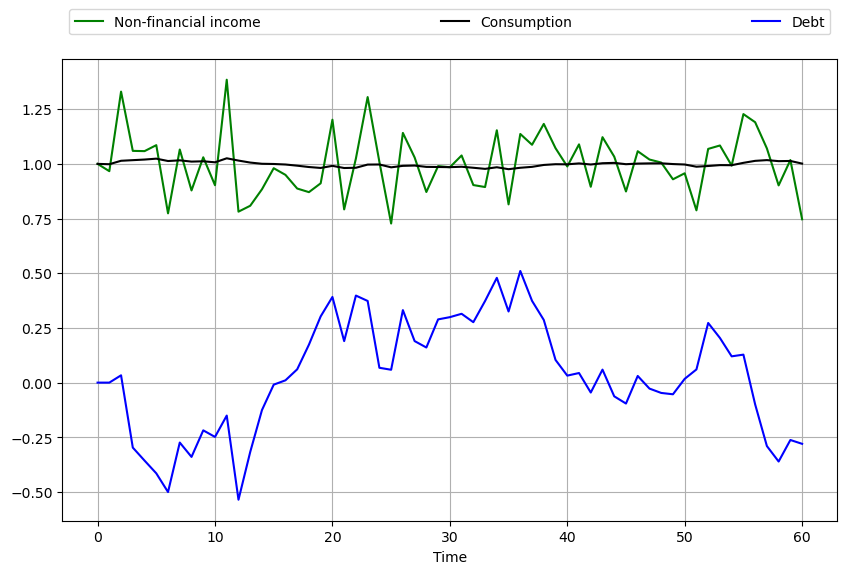

In [3]:
r = 0.05
β = 1 / (1 + r)
σ = 0.15
μ = 1
T = 60

@njit
def time_path(T):
    w = np.random.randn(T+1)  # w_0, w_1, ..., w_T
    w[0] = 0
    b = np.zeros(T+1)
    for t in range(1, T+1):
        b[t] = w[1:t].sum()
    b = -σ * b
    c = μ + (1 - β) * (σ * w - b)
    return w, b, c

w, b, c = time_path(T)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(μ + σ * w, 'g-', label="Non-financial income")
ax.plot(c, 'k-', label="Consumption")
ax.plot( b, 'b-', label="Debt")
ax.legend(ncol=3, mode='expand', bbox_to_anchor=(0., 1.02, 1., .102))
ax.grid()
ax.set_xlabel('Time')

plt.show()

Observe that consumption is considerably smoother than income.

The figure below shows the consumption paths of 250 consumers with independent income streams

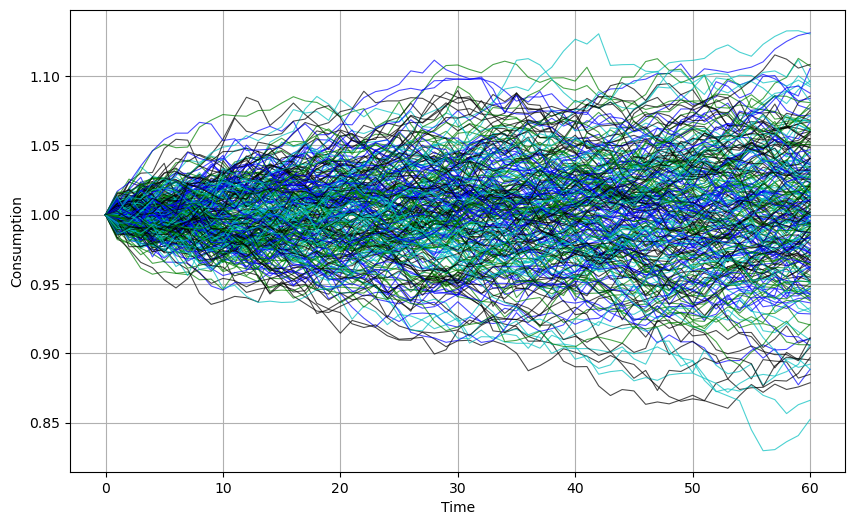

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

b_sum = np.zeros(T+1)
for i in range(250):
    w, b, c = time_path(T)  # Generate new time path
    rcolor = random.choice(('c', 'g', 'b', 'k'))
    ax.plot(c, color=rcolor, lw=0.8, alpha=0.7)

ax.grid()
ax.set(xlabel='Time', ylabel='Consumption')

plt.show()

## Alternative Representations

In this section, we shed more light on the evolution of savings, debt and
consumption by representing their dynamics in several different ways.

### Hall's Representation

```{index} single: Permanent Income Model; Hall's Representation
```

Hall {cite}`Hall1978` suggested an insightful way to summarize the implications of LQ permanent income theory.

First, to represent the solution for $b_t$, shift {eq}`sprob8` forward one period and eliminate $b_{t+1}$ by using {eq}`sprob2` to obtain

$$
c_{t+1} = (1-\beta)\sum_{j=0}^\infty \beta^j  \mathbb{E}_{t+1} [y_{t+j+1}] -
(1-\beta) \left[ \beta^{-1} (c_t + b_t - y_t) \right]
$$

If we add and subtract $\beta^{-1} (1-\beta) \sum_{j=0}^\infty \beta^j \mathbb{E}_t y_{t+j}$ from the right side of the preceding equation and rearrange, we obtain

```{math}
:label: sprob11

c_{t+1} - c_t = (1-\beta) \sum_{j=0}^\infty \beta^j
    \left\{ \mathbb{E}_{t+1} [y_{t+j+1}] - \mathbb{E}_t [y_{t+j+1}] \right\}
```

The right side is the time $t+1$ *innovation to the expected present value* of the endowment process $\{y_t\}$.

We can represent the optimal decision rule for $(c_t, b_{t+1})$ in the form of {eq}`sprob11` and {eq}`sprob7`, which we repeat:

```{math}
:label: sprob7aa

b_t = \sum_{j=0}^\infty \beta^j \mathbb{E}_t [y_{t+j}] - {1 \over 1-\beta} c_t
```

Equation {eq}`sprob7aa` asserts that the consumer's debt due at $t$ equals the expected present value of its endowment minus the expected present value of its consumption stream.

A high debt thus indicates a large expected present value of surpluses $y_t - c_t$.

Recalling again our discussion on {ref}`forecasting geometric sums <lm_fgs>`, we have

$$
\begin{aligned}
    \mathbb{E}_t \sum_{j=0}^\infty \beta^j y_{t+j} &= U (I-\beta A)^{-1} z_t \\
    \mathbb{E}_{t+1} \sum_{j=0}^\infty \beta^j y_{t+j+1} & = U (I -\beta A)^{-1} z_{t+1} \\
    \mathbb{E}_t \sum_{j=0}^\infty \beta^j y_{t+j+1} & = U (I - \beta A)^{-1} A z_t
\end{aligned}
$$

Using  these formulas together with {eq}`sprob15ab` and substituting  into {eq}`sprob11` and {eq}`sprob7aa`  gives the following representation for the consumer's optimum decision rule:

```{math}
:label: sprob16abcd

\begin{aligned}
    c_{t+1} & = c_t + (1-\beta) U  (I-\beta A)^{-1} C w_{t+1} \\
    b_t & = U (I-\beta A)^{-1} z_t - {1 \over 1-\beta} c_t \\
    y_t & = U z_t \\
    z_{t+1} & = A z_t + C w_{t+1}
\end{aligned}
```

Representation {eq}`sprob16abcd` makes clear that

* The state can be taken as $(c_t, z_t)$.
    * The endogenous part is $c_t$ and the exogenous part is $z_t$.
    * Debt $b_t$ has disappeared as a component of the state because it is encoded in $c_t$.
* Consumption is a random walk with innovation $(1-\beta) U  (I-\beta A)^{-1} C w_{t+1}$.
    * This is a more explicit representation of the martingale result in {eq}`sprob5`.

(coint_pi)=
### Cointegration

Representation {eq}`sprob16abcd` reveals that the joint process $\{c_t, b_t\}$ possesses the property that Engle and Granger {cite}`EngleGranger1987` called [cointegration](https://en.wikipedia.org/wiki/Cointegration).

Cointegration is a tool that allows us to apply powerful results from the theory of stationary stochastic processes to (certain transformations of) nonstationary models.

To apply cointegration in the present context, suppose that $z_t$ is asymptotically stationary [^fn_as].

Despite this, both $c_t$ and $b_t$ will be non-stationary because they have unit roots (see {eq}`pi_ssr` for $b_t$).

Nevertheless, there is a linear combination of $c_t, b_t$ that *is* asymptotically stationary.

In particular, from the second equality in {eq}`sprob16abcd` we have

```{math}
:label: pi_spr

(1-\beta) b_t + c_t = (1 - \beta) U (I-\beta A)^{-1} z_t
```

Hence the linear combination $(1-\beta) b_t + c_t$ is asymptotically stationary.

Accordingly, Granger and Engle would call $\begin{bmatrix} (1-\beta) & 1 \end{bmatrix}$ a **cointegrating vector** for the state.

When applied to the nonstationary vector process $\begin{bmatrix} b_t  & c_t \end{bmatrix}'$, it yields a process that is asymptotically stationary.

Equation {eq}`pi_spr` can be rearranged to take the form

```{math}
:label: sprob77

(1-\beta) b_t + c_t = (1-\beta) \mathbb{E}_t \sum_{j=0}^\infty \beta^j y_{t+j}
```

Equation {eq}`sprob77`  asserts that the *cointegrating residual*  on the left side equals the conditional expectation of the geometric sum of future incomes on the right [^f8].

### Cross-Sectional Implications

Consider again {eq}`sprob16abcd`, this time in light of our discussion of
distribution dynamics in the {doc}`lecture on linear systems <linear_models>`.

The dynamics of $c_t$ are given by

```{math}
:label: pi_crw

c_{t+1} = c_t + (1-\beta) U  (I-\beta A)^{-1} C w_{t+1}
```

or

$$
c_t = c_0 + \sum_{j=1}^t \hat w_j
\quad \text{for} \quad
\hat w_{t+1} := (1-\beta) U  (I-\beta A)^{-1} C w_{t+1}
$$

The unit root affecting $c_t$ causes the time $t$ variance of $c_t$ to grow linearly with $t$.

In particular, since $\{ \hat w_t \}$ is IID, we have

```{math}
:label: pi_vt

\mathrm{Var}[c_t] = \mathrm{Var}[c_0] + t \, \hat \sigma^2
```

where

$$
\hat \sigma^2 := (1-\beta)^2 U  (I-\beta A)^{-1} CC' (I-\beta A')^{-1} U'
$$

When $\hat \sigma > 0$, $\{c_t\}$ has no asymptotic distribution.

Let's consider what this means for a cross-section of ex-ante identical consumers born at time $0$.

Let the distribution of $c_0$ represent the cross-section of initial consumption values.

Equation {eq}`pi_vt` tells us that the variance of $c_t$ increases over time at a rate proportional to $t$.

A number of different studies have investigated this prediction and found some support for it
(see, e.g., {cite}`DeatonPaxton1994`, {cite}`STY2004`).

### Impulse Response Functions

Impulse response functions measure responses  to various  impulses (i.e., temporary shocks).

The impulse response function of $\{c_t\}$ to the innovation $\{w_t\}$ is a box.

In particular, the response of $c_{t+j}$ to a unit increase in the innovation $w_{t+1}$ is $(1-\beta) U (I -\beta A)^{-1} C$ for all $j \geq 1$.

### Moving Average Representation

It's useful to express the innovation to the expected present value of the endowment process in terms of a moving average representation for income $y_t$.

The endowment process defined by {eq}`sprob15ab` has the moving average representation

```{math}
:label: sprob12

y_{t+1} = d(L) w_{t+1}
```

where

* $d(L) = \sum_{j=0}^\infty d_j L^j$ for some sequence $d_j$, where $L$ is the lag operator [^f4]
* at time $t$, the consumer has an information set [^f5] $w^t = [w_t, w_{t-1}, \ldots ]$

Notice that

$$
y_{t+j} - \mathbb{E}_t [y_{t+j}] = d_0 w_{t+j} + d_1 w_{t+j-1} + \cdots + d_{j-1} w_{t+1}
$$

It follows that

```{math}
:label: sprob120

\mathbb{E}_{t+1} [y_{t+j}] - \mathbb{E}_t [y_{t+j}] = d_{j-1} w_{t+1}
```

Using {eq}`sprob120` in {eq}`sprob11` gives

```{math}
:label: sprob13

c_{t+1} - c_t = (1-\beta) d(\beta) w_{t+1}
```

The object $d(\beta)$ is the **present value of the moving average coefficients** in the representation for the endowment process $y_t$.

(sub_classic_consumption)=
## Two Classic Examples

We illustrate some of the preceding ideas with two examples.

In both examples, the endowment follows the process $y_t = z_{1t} + z_{2t}$ where

$$
\begin{bmatrix}
  z_{1 t+1} \\
  z_{2t+1}
\end{bmatrix} =
\begin{bmatrix}
  1 & 0 \\
  0 & 0
\end{bmatrix}
\begin{bmatrix}
  z_{1t} \\
  z_{2t}
\end{bmatrix} + \begin{bmatrix}
      \sigma_1 & 0 \\
      0 & \sigma_2
  \end{bmatrix}
  \begin{bmatrix}
      w_{1t+1} \\
      w_{2t+1}
  \end{bmatrix}
$$

Here

* $w_{t+1}$ is an IID $2 \times 1$ process distributed as $N(0,I)$.
* $z_{1t}$ is a permanent component of $y_t$.
* $z_{2t}$ is a purely transitory component of $y_t$.

### Example 1

Assume as before that the consumer observes the state $z_t$ at time $t$.

In view of {eq}`sprob16abcd` we have

```{math}
:label: consexample1

c_{t+1} - c_t = \sigma_1 w_{1t+1} + (1-\beta) \sigma_2 w_{2t+1}
```

Formula {eq}`consexample1` shows how an increment $\sigma_1 w_{1t+1}$ to the permanent component of income $z_{1t+1}$ leads to

* a permanent one-for-one increase in consumption and
* no increase in savings $-b_{t+1}$

But the purely transitory component of income $\sigma_2 w_{2t+1}$ leads to a permanent increment in consumption by a fraction $1-\beta$ of transitory income.

The remaining fraction $\beta$ is saved, leading to a permanent increment in $-b_{t+1}$.

Application of the formula for debt in {eq}`pi_ssr` to this example shows that

```{math}
:label: consexample1a

b_{t+1} - b_t = - z_{2t} = - \sigma_2 w_{2t}
```

This confirms that none of $\sigma_1 w_{1t}$ is saved, while all of $\sigma_2 w_{2t}$ is saved.

The next figure displays impulse-response functions that  illustrates these very different reactions to transitory and
permanent income shocks.

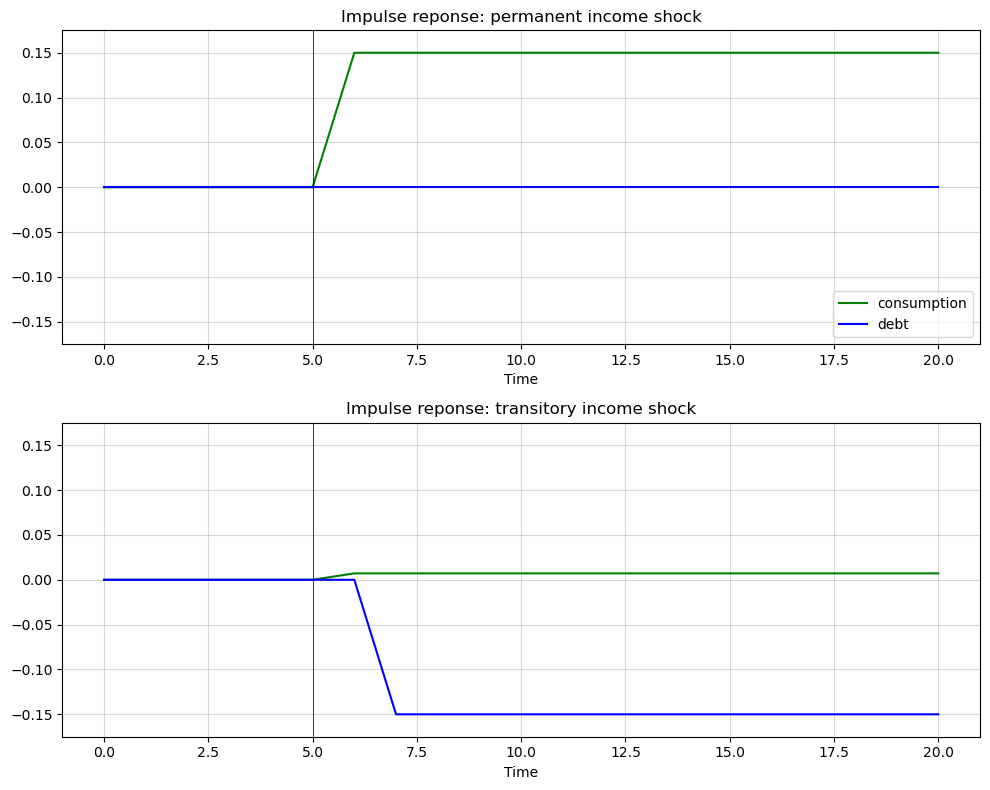

In [5]:
r = 0.05
β = 1 / (1 + r)
S = 5   # Impulse date
σ1 = σ2 = 0.15

@njit
def time_path(T, permanent=False):
    "Time path of consumption and debt given shock sequence"
    w1 = np.zeros(T+1)
    w2 = np.zeros(T+1)
    b = np.zeros(T+1)
    c = np.zeros(T+1)
    if permanent:
        w1[S+1] = 1.0
    else:
        w2[S+1] = 1.0
    for t in range(1, T):
        b[t+1] = b[t] - σ2 * w2[t]
        c[t+1] = c[t] + σ1 * w1[t+1] + (1 - β) * σ2 * w2[t+1]
    return b, c


fig, axes = plt.subplots(2, 1, figsize=(10, 8))
titles = ['permanent', 'transitory']

L = 0.175

for ax, truefalse, title in zip(axes, (True, False), titles):
    b, c = time_path(T=20, permanent=truefalse)
    ax.set_title(f'Impulse reponse: {title} income shock')
    ax.plot(c, 'g-', label="consumption")
    ax.plot(b, 'b-', label="debt")
    ax.plot((S, S), (-L, L), 'k-', lw=0.5)
    ax.grid(alpha=0.5)
    ax.set(xlabel=r'Time', ylim=(-L, L))

axes[0].legend(loc='lower right')

plt.tight_layout()
plt.show()

Notice how the permanent income shock provokes no change in  assets $-b_{t+1}$ and an immediate  permanent change in consumption equal to the permanent increment in non-financial income.

In contrast, notice how most of a transitory income shock is saved and only a small amount is saved.

The box-like impulse responses of consumption to both types of shock reflect the random walk property of the optimal consumption decision.

### Example 2

Assume now that at time $t$ the consumer observes $y_t$, and its history up to $t$, but not $z_t$.

Under this assumption, it is appropriate to use an *innovation representation* to form $A, C, U$ in {eq}`sprob16abcd`.

The discussion in sections 2.9.1 and 2.11.3 of {cite}`Ljungqvist2012` shows that the pertinent state space representation for $y_t$ is

$$
\begin{aligned}
  \begin{bmatrix}
    y_{t+1} \\
    a_{t+1}
  \end{bmatrix}
    & =
    \begin{bmatrix}
        1 & -(1 - K) \\
        0 & 0
    \end{bmatrix}
    \begin{bmatrix}
        y_t \\
        a_t
    \end{bmatrix} +
    \begin{bmatrix}
        1 \\
        1
    \end{bmatrix}
    a_{t+1}
    \\
    y_t
    & =
    \begin{bmatrix}
        1 & 0
    \end{bmatrix}
    \begin{bmatrix}
        y_t \\
        a_t
    \end{bmatrix}
\end{aligned}
$$

where

* $K :=$ the stationary Kalman gain
* $a_t := y_t - E [ y_t \,|\, y_{t-1}, \ldots, y_0]$

In the same discussion in {cite}`Ljungqvist2012` it is shown that $K \in [0,1]$ and that $K$ increases as $\sigma_1/\sigma_2$ does.

In other words, $K$ increases as the ratio of the standard deviation of the permanent shock to that of the transitory shock increases.

Please see  {doc}`first look at the Kalman filter <kalman>`.

Applying formulas {eq}`sprob16abcd` implies

```{math}
:label: consexample2

c_{t+1} - c_t = [1-\beta(1-K) ] a_{t+1}
```

where the endowment process can now be represented in terms of the univariate innovation to $y_t$ as

```{math}
:label: incomemaar

y_{t+1} - y_t = a_{t+1} - (1-K) a_t
```

Equation {eq}`incomemaar` indicates that the consumer regards

* fraction $K$ of an innovation $a_{t+1}$ to $y_{t+1}$ as *permanent*
* fraction $1-K$ as purely transitory

The consumer permanently increases his consumption by the full amount of his estimate of the permanent part of $a_{t+1}$, but by only $(1-\beta)$ times his estimate of the purely transitory part of $a_{t+1}$.

Therefore, in total, he permanently increments his consumption by a fraction $K + (1-\beta) (1-K) = 1 - \beta (1-K)$ of $a_{t+1}$.

He saves the remaining fraction $\beta (1-K)$.

According to equation {eq}`incomemaar`, the first difference of income is a first-order moving average.

Equation  {eq}`consexample2` asserts that the first difference of consumption is IID.

Application of formula to this example shows that

```{math}
:label: consexample1b

b_{t+1} - b_t = (K-1) a_t
```

This indicates how the fraction $K$ of the innovation to $y_t$ that is regarded as permanent influences the fraction of the innovation that is saved.

## Further Reading

The model described above significantly changed how economists think about
consumption.

While Hall's model does a remarkably good job as a first approximation to consumption data, it's widely believed that it doesn't capture important aspects of some consumption/savings data.

For example, liquidity constraints and precautionary savings appear to be present sometimes.

Further discussion can be found in, e.g., {cite}`HallMishkin1982`, {cite}`Parker1999`, {cite}`Deaton1991`, {cite}`Carroll2001`.

(perm_income_appendix)=
## Appendix: The Euler Equation

Where does the first-order condition {eq}`sprob4` come from?

Here we'll give a proof for the two-period case, which is representative of
the general argument.

The finite horizon equivalent of the no-Ponzi condition is that the agent
cannot end her life in debt, so $b_2 = 0$.

From the budget constraint {eq}`sprob2` we then have

$$
c_0 = \frac{b_1}{1 + r} - b_0 + y_0
\quad \text{and} \quad
c_1 = y_1 - b_1
$$

Here $b_0$ and $y_0$ are given constants.

Substituting these constraints into our two-period objective $u(c_0) + \beta \mathbb{E}_0 [u(c_1)]$ gives

$$
\max_{b_1}
 \left\{
     u \left(\frac{b_1}{R} - b_0 + y_0 \right) +
     \beta \, \mathbb{E}_0 [ u (y_1 - b_1) ]
\right\}
$$

You will be able to verify that the first-order condition is

$$
u'(c_0) = \beta R  \,\mathbb{E}_0 [u'(c_1)]
$$

Using $\beta R = 1$ gives {eq}`sprob4` in the two-period case.

The proof for the general case is similar.

[^f2]: A linear marginal utility is essential for deriving {eq}`sprob5` from {eq}`sprob4`.  Suppose instead that we had imposed the following more standard assumptions on the utility function: $u'(c) >0, u''(c)<0, u'''(c) > 0$ and required that $c \geq 0$.  The Euler equation remains {eq}`sprob4`. But the fact that $u''' <0$ implies via Jensen's inequality that $\mathbb{E}_t [u'(c_{t+1})] >  u'(\mathbb{E}_t [c_{t+1}])$.  This inequality together with {eq}`sprob4` implies that $\mathbb{E}_t [c_{t+1}] > c_t$ (consumption is said to be a 'submartingale'), so that consumption stochastically diverges to $+\infty$.  The consumer's savings also diverge to $+\infty$.

[^fod]: An optimal decision rule is a map from the current state into current actions---in this case, consumption.

[^f4]: Representation {eq}`sprob15ab` implies that $d(L) = U (I - A L)^{-1} C$.

[^fn_as]: This would be the case if, for example, the {ref}`spectral radius <la_neumann_remarks>` of $A$ is strictly less than one.

[^f5]: A moving average representation for a process $y_t$ is said to be **fundamental** if the linear space spanned by $y^t$ is equal to the linear space spanned by $w^t$.  A time-invariant innovations representation, attained via the Kalman filter, is by construction fundamental.

[^f8]: See {cite}`CampbellShiller88`, {cite}`LettLud2001`, {cite}`LettLud2004` for interesting applications of related ideas.